# Deep Learning Project (DD2424)


## -- INITIAL SETUP --

### 0.1 Download datasets

In [3]:
download_data = False

In [4]:
if download_data:
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

    !mkdir oxford-iiit-pet/
    !tar -xf images.tar.gz -C oxford-iiit-pet/
    !tar -xf annotations.tar.gz -C oxford-iiit-pet/
    !rm images.tar.gz
    !rm annotations.tar.gz

else:
    print("Note: Assuming that data is manually downloaded!")
    # --> Alternative is to manually download datasets here: https://www.robots.ox.ac.uk/~vgg/data/pets/
    #  Note: must have the folder "oxford-iiit-pet" in same directory as code/notebook

Note: Assuming that data is manually downloaded!


### 0.2 Define Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torchvision

from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.ops.boxes import masks_to_boxes

from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import transforms

### 0.3 Example plot

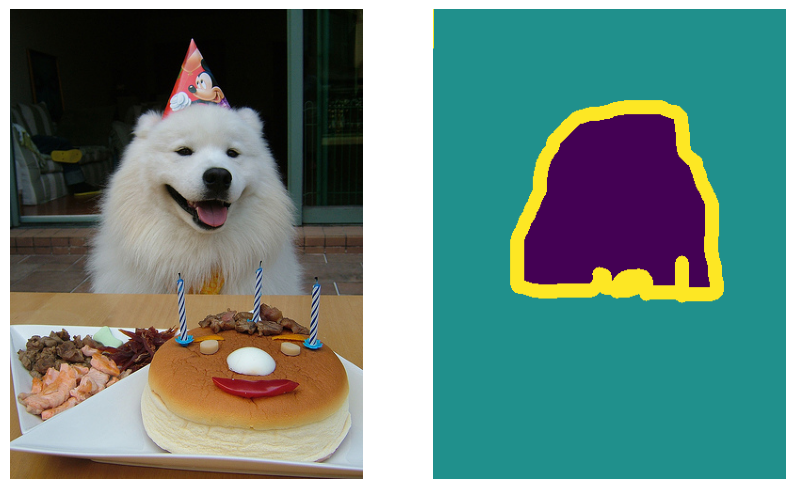

In [6]:
from torchvision.io import read_image

# -- PLOT EXAMPLE IMAGE AND MASK --
name = 'samoyed_189'
img = read_image(f'oxford-iiit-pet/images/{name}.jpg')
mask = read_image(f'oxford-iiit-pet/annotations/trimaps/{name}.png')

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.subplot(122)
plt.imshow(mask.permute(1, 2, 0))
plt.axis('off')
plt.show()

## -- DATA PREPROCESSING --


### 1.1 Define datasets and dataloaders and subset splits (train, validation, test):

In [7]:
# --------- Transform pipeline ---------

def transform_pipeline(in_data):
    # Define an ordered collection of functions/transformations to apply to all images
    pipeline = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])
    return pipeline(in_data)

def load_dataset(target_type="binary-category"):
    ttransform = target_transform if target_type=="category" else None
    # Load in all the data within file 'trainval.txt'
    return OxfordIIITPet(root='.', download=False, transform=transform_pipeline, target_transform=ttransform, target_types=[target_type] )
    #return dataset

def target_transform(target):

    hot = torch.zeros((37))

    hot[target-1] = 1
    #cat_classes = {6, 34, 12, 27, 33, 7, 24, 21, 10, 28, 1, 8}  # set lookup is faster
    #return 0 if target in cat_classes else 1

    return hot   # if we use ["binary-category"]

def create_split_idxs(n_tot, f_train=0.8, f_valid=0.1, f_test=0.1):

    if f_train + f_valid + f_test > 1:
        print("ERROR: FACTORS TOO LARGE TO CREATE SPLITS, TRY AGAIN")

    # Range from index 0 to n==len(dataset)
    idxes = np.arange(n_tot)
    np.random.seed(42)   # random seed to ensure repeatability
    np.random.shuffle(idxes)

    # split limits:
    s1 = int(n_tot*f_train)
    s2 = int(n_tot*(f_train+f_valid))

    # Create index lists
    train_idx = idxes[:s1]
    val_idx = idxes[s1:s2]
    test_idx = idxes[s2:]

    return train_idx, val_idx, test_idx


def get_dataloaders(n_batch, f_train=0.8, f_valid=0.1, f_test=0.1, target_type="binary-category"):
    # Load in all data
    dataset = load_dataset(target_type=target_type)

    # Test it
    image, label = dataset[0]
    print(f"Image shape: {image.shape}")

    # Create shuffled index splitting for each subset
    train_idx, val_idx, test_idx = create_split_idxs(len(dataset), f_train, f_valid, f_test)

    # Split using imported Subset class
    dataset_train = Subset(dataset, train_idx)
    dataset_test = Subset(dataset, test_idx)
    dataset_val = Subset(dataset, val_idx)

    # Create data loader containing datasets
    dataloader_train = DataLoader(dataset_train, batch_size=n_batch, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=n_batch, shuffle=False, num_workers=2)
    dataloader_val = DataLoader(dataset_val, batch_size=n_batch, shuffle=True, num_workers=2)

    return dataloader_train, dataloader_test, dataloader_val


### 1.2 Plot random example images to show pre-processing (scaling and cropping)

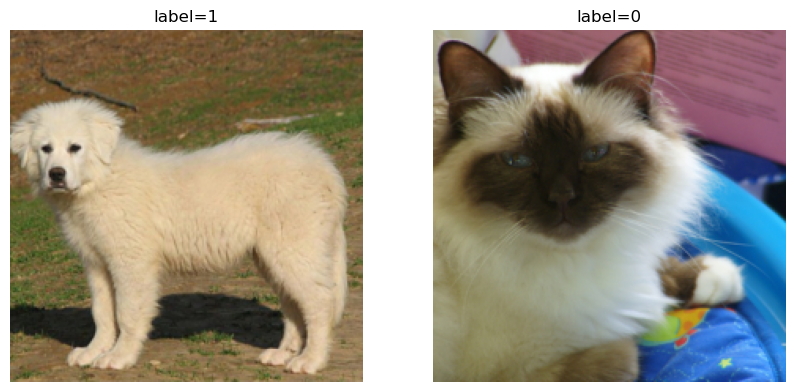

In [8]:
dataset = load_dataset()

#print(len(dataset[0]))

# plot example image
plt.figure(figsize=(10, 10))
plt.subplot(121)

dog = 2600
plt.imshow(dataset[dog][0].permute(1, 2, 0))
plt.axis('off')
plt.title(f"label={dataset[dog][1]}")
plt.subplot(122)

cat = 300
plt.imshow(dataset[cat][0].permute(1, 2, 0))
plt.title(f"label={dataset[cat][1]}")

plt.axis('off')

plt.show()


### (maybe todo) 1.3 Define zero-mean normalization across all data

In [9]:
def zero_mean(dataloader):
    # TODO: FIXME IF WE WANT TO DO ZERO MEAN NORMALIZATION

    #print(next(iter(dataloader_test))[0].shape)  # torch.Size([64, 3, 224, 224])
    #img = next(iter(dataloader_test))[0][0]
    #print(img.max())
    #print(img.min())
    #print(max(next(iter(dataloader_test))))

    img, _ = next(iter(dataloader))
    img = img[0]
    print(f'max: {torch.max(img)}')
    print(f'min: {torch.min(img)}')
    print(f'mean: {torch.mean(img)}')


## -- NETWORK SETUP --

### 2.0 Network Imports

In [10]:
from torchvision.models import resnet18
from torchvision.models import resnet34
from torchvision.models import resnet50
from torchvision.models import resnet101
from torchvision.models import wide_resnet50_2
#from torchvision.models import resnet152

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


### 2.1 Define model and training functions

In [11]:
def create_model_and_optim_binary(choice="resnet34", lr=0.001, wd=0.0005):

    # Load in pretrained model of our choice:
    if choice == "resnet18":
        model = resnet18(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet34":
        model = resnet34(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet50":
        model = resnet50(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet101":
        model = resnet101(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    else:
        print("model choice does not match")
        exit()

    # As instructed, only replace final layer with same in but one out (cat/dog)
    in_features = model.fc.in_features   # size of input of final layer --> 512
    #print(model.fc.out_features)   # size of output into final layer --> 1000

    # Create a new Linear layer to replace last fc layer with:
    model.fc = torch.nn.Linear(in_features, 1)  # for binary classification instead of outputting 1000

    # Freeze all layers before final layer which we will replace
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True   # update these layer weights (only last)

    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, weight_decay=wd)
    # TODO: maybe look into NAG as alternative

    return model, optimizer


def train_binary(model, dataloader, optimizer, epochs=1):
    losses = []

    model = model.to(device)

    model.train()  # tells model we will train now maybe
    criterion = torch.nn.BCEWithLogitsLoss()
    # trains in batches
    for e in range(epochs):

        running_loss = 0.0

        # for each batch:
        for i, (img, binary_category) in enumerate(dataloader):

            #print(img.shape)  # torch.Size([64, 3, 224, 224])

            img = img.to("cuda")
            binary_category = binary_category.to("cuda")

            # Forward pass of network
            output = model(img)

            # Compute loss
            # TODO: check if we want to use another loss function
            loss = criterion(output, binary_category.view(-1, 1).float())

            # Compute gradients
            loss.backward()

            # Backprop
            optimizer.step()  # update weights with grads

            batch_loss = loss.item()

            losses.append(batch_loss)
            running_loss += batch_loss

            print(f"\r Epoch {e+1}/{epochs} : Batch {i+1}/{len(dataloader)} : Loss {batch_loss}", end="")

            optimizer.zero_grad()  # reset grads

    return losses


## -- NETWORK TRAINING --

### 2.3 Initialize data

In [12]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="binary-category")

print("done loading data")
print("number of batches:", len(dataloader_train))

Image shape: torch.Size([3, 224, 224])
done loading data
number of batches: 81


### 2.3 Initialize model

In [13]:
print(f"cuda == {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_binary, optimizer_binary = create_model_and_optim_binary(choice="resnet34", lr=0.001, wd=0.0005)


cuda == True


### 2.4 Train binary network

In [14]:
#print(torch.cuda.get_device_name(0))  # Tesla P4

print("Start training")
losses = train_binary(model_binary, dataloader_train, optimizer_binary, epochs=1)


Start training
 Epoch 1/1 : Batch 81/81 : Loss 0.17353062331676483

### 2.5 Plot losses and compute accuracy

In [15]:
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_losses(losses):
    #losses_cpu = [loss.cpu().detach().numpy() for loss in losses]
    losses_cpu = [loss for loss in losses]
    #plt.plot(smooth(losses_cpu))
    plt.plot(losses_cpu)
    plt.xlabel("batch nr")
    plt.ylabel("training loss")


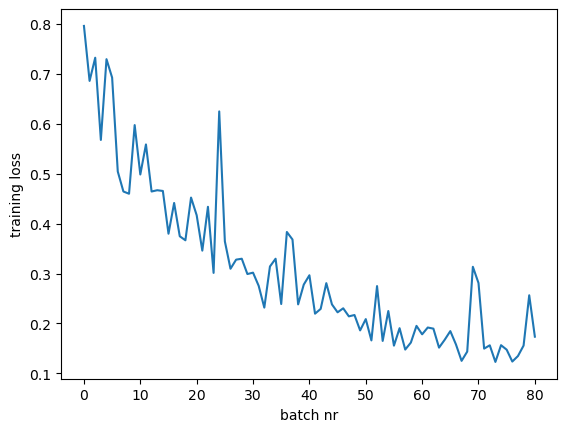

In [16]:
# Plot
plot_losses(losses)


### 2.6 Binary Accuracy

In [17]:
# TODO: FIXME
def compute_accuracy_binary(model, dataloader_test):
    total = 0
    correct = 0

    # no grad so it's faster (--> Julia edit: 'no_grad()' ensures that we can calculate with tensors without affecting it's gradients in backprop)
    with torch.no_grad():

        model.eval()

        for i, (img, binary_category) in enumerate(dataloader_test):
            img = img.to("cuda")
            binary_category = binary_category.to("cuda").view(-1, 1).float()   # torch.Size([32, 1])

            output = model(img)                                     # torch.Size([32, 1])
            prediction = torch.round(torch.sigmoid(output))         # torch.Size([32, 1])

            total += binary_category.size(0)
            correct += (prediction == binary_category).sum().item()

            print(f'\r({i+1}/{len(dataloader_test)}) accuracy: {100 * correct / total} %', end="")
        print(f'\nTest accuracy: {100 * correct / total} %')


def compute_confusion_matrix():
    pass

In [18]:
# NOTE/WARNING:
compute_accuracy_binary(model_binary, dataloader_test)

(12/12) accuracy: 97.289972899729 %%
Test accuracy: 97.289972899729 %


## -- MULTICLASS --

### 3.1 Modify network for multiclass classification

In [224]:
def create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=1, separate_scheduler=False):

    # Load in pretrained model of our choice:
    if choice == "resnet18":
        model = resnet18(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet34":
        model = resnet34(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet50":
        model = resnet50(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet101":
        model = resnet101(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    else:
        print("model choice does not match")
        exit()

    # Create a new Linear layer to replace last fc layer with:
    model.fc = torch.nn.Linear(model.fc.in_features, 37)  # for binary classification instead of outputting 1000

    modules = [model.fc, model.layer4, model.layer3, model.layer2, model.layer1]
    layers_to_unfreeze = modules[:n_freeze]

    # Freeze all layers before final layer which we will replace
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the ones we want
    for layer in layers_to_unfreeze:
        #print("freeeeze")
        for param in layer.parameters():
            param.requires_grad = True

    optimizers = []
    schedulers = []

    if separate_scheduler:
        for i, layer in enumerate(layers_to_unfreeze):
            optimizers.append(torch.optim.Adam(
                filter(lambda p: p.requires_grad, layer.parameters()),
                lr=lr*0.1**i, # exponential decay of lr for each layer
                weight_decay=wd
            ))
            schedulers.append(torch.optim.lr_scheduler.StepLR(optimizers[i], step_size=3, gamma=0.1))
    else:
        optimizers.append(torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=lr,
            weight_decay=wd
        ))

        schedulers.append(torch.optim.lr_scheduler.StepLR(optimizers[0], step_size=3, gamma=0.1))

    return model, optimizers, schedulers

def train_multi(model, dataloader, optimizers, epochs=1, schedulers=[], weight=None):
    losses = []
    model = model.to(device)
    model.train()  # tells model we will train now maybe
    criterion = torch.nn.CrossEntropyLoss(weight=weight)

    # trains in batches
    for e in range(epochs):
        running_loss = 0.0
        # for each batch:
        for i, (img, category) in enumerate(dataloader):
            img = img.to("cuda")
            category = category.squeeze().float().to("cuda")
            output = model(img) # Forward pass of network

            loss = criterion(output, category) # TODO: check if we want to use another loss function
            loss.backward() # Compute gradients
            for optimizer in optimizers:
                optimizer.step()# Backprop # update weights with grads
            batch_loss = loss.item()
            losses.append(batch_loss)
            running_loss += batch_loss
            print(f"\r Epoch {e+1}/{epochs} : Batch {i+1}/{len(dataloader)} : Loss {batch_loss}", end="")
            optimizer.zero_grad()  # reset grads
        for scheduler in schedulers:
            scheduler.step()

    return losses

### 3.2 Load in multiclass data

In [20]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="category")

print("done loading multiclass data")
print("number of batches:", len(dataloader_train))


Image shape: torch.Size([3, 224, 224])
done loading multiclass data
number of batches: 81


### 3.3 Initialize model

In [111]:
### 2.3 Initialize model, train, and plot losses
print(f"cuda == {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1, optimizers1, schedulers1 = create_model_and_optim_multi(choice="resnet50", lr=0.0005, wd=0.0005, n_freeze=3)
#model2, optimizer2, scheduler2 = create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=2)
#model3, optimizer3, scheduler3 = create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=3)


cuda == True


### 3.4 Train multiclass model

In [112]:
print("Start training")
losses = train_multi(model1, dataloader_train, optimizers1, epochs=10, schedulers=schedulers1)
#losses2 = train_multi(model2, dataloader_train, optimizer2, epochs=1)
#losses3 = train_multi(model3, dataloader_train, optimizer3, epochs=1)

Start training
 Epoch 10/10 : Batch 81/81 : Loss 0.0396052971482276916

### 3.5 Multiclass metric calculations

In [156]:
# TODO: FIXME
def compute_accuracy_multi(model, dataloader_test):
    total = 0
    correct = 0
    model = model.to(device)

    # no grad so it's faster (--> Julia edit: I think 'no_grad()' ensures that we can calculate with tensors without affecting its gradients in backprop)
    with torch.no_grad():
        model.eval()
        for i, (img, category) in enumerate(dataloader_test):
            img = img.to("cuda")
            category = torch.argmax(category, axis=1).to("cuda")  # torch.Size([32, 37]) ---> torch.Size([32])

            output = model(img)  # torch.Size([32, 37])
            # from output choose class/index with the highest value (probability?)
            prediction = torch.argmax(output, axis=1)   # torch.Size([32])

            total += category.size(0)
            correct += (prediction == category).sum().item()

    return correct / total


In [124]:
def get_predictions(model, dataloader_test):
    model = model.to(device)
    predictions = np.zeros((len(dataloader_test.dataset)))

    # no grad so it's faster (--> Julia edit: I think 'no_grad()' ensures that we can calculate with tensors without affecting its gradients in backprop)
    with torch.no_grad():
        model.eval()
        for i, (img, category) in enumerate(dataloader_test):
            img = img.to("cuda")
            category = torch.argmax(category, axis=1).to("cuda")  # torch.Size([32, 37]) ---> torch.Size([32])

            output = model(img)  # torch.Size([32, 37])
            # from output choose class/index with the highest value (probability?)
            prediction = torch.argmax(output, axis=1)   # torch.Size([32])
            predictions[i*32:(i+1)*32] = prediction.cpu().numpy()

    return predictions

Calculate precision and recall, then F1 macro score.

$ precision = \frac{TP}{TP + FP} $

$ recall = \frac{TP}{TP + FN} $

$ F_1 = \frac{2}{recall^{-1} + precision^{-1}} = \frac{2TP}{2TP + FP + FN}$

Plot distribution of true classes and predicted classes:

In [129]:
def compute_confusion_matrix(preds, y_test):
    TP = np.zeros((37))
    FP = np.zeros((37))
    TN = np.zeros((37))
    FN = np.zeros((37))

    for i in range(len(preds)):
        if preds[i] == y_test[i]:
            TP[int(preds[i])] += 1
        else:
            FP[int(preds[i])] += 1
            FN[int(y_test[i])] += 1
            TN[int(y_test[i])] += 1

    return TP, FP, TN, FN

# find f1 score for each class
def f1_score(TP, FP, TN, FN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1.mean()

In [ ]:
### 3.6 Strategy comparisons - Fine-tuning experiments for grade E

# Strategy 1: Fine-tune l layers simultaneously
def strategy1_experiments(choice="resnet34", lr=0.001, wd=0.0005):
    """Strategy 1: Fine-tune l layers simultaneously"""
    results = {}
    dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="category")
    
    for l in range(1, 5):  # Fine-tune last l layers
        print(f"\n--- Fine-tuning last {l} layers ---")
        model, optimizers, schedulers = create_model_and_optim_multi(choice=choice, lr=lr, wd=wd, n_freeze=l)
        
        # Train the model
        losses = train_multi(model, dataloader_train, optimizers, epochs=5, schedulers=schedulers)
        
        # Evaluate on validation and test sets
        print("Validation accuracy:")
        val_acc = compute_accuracy_multi(model, dataloader_val)
        print("Test accuracy:")
        test_acc = compute_accuracy_multi(model, dataloader_test)
        
        results[f"l={l}"] = {
            "losses": losses,
            "val_accuracy": 100 * val_acc,
            "test_accuracy": 100 * test_acc
        }
    
    return results

# Strategy 2: Gradual unfreezing
def strategy2_experiments(choice="resnet34", lr=0.001, wd=0.0005):
    """Strategy 2: Gradual unfreezing"""
    dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="category")
    
    # Start with just the final layer
    model, optimizers, schedulers = create_model_and_optim_multi(choice=choice, lr=lr, wd=wd, n_freeze=1)
    
    results = {}
    total_losses = []
    
    for stage in range(1, 5):  # Gradually unfreeze more layers
        print(f"\n--- Stage {stage}: Fine-tuning last {stage} layers ---")
        
        # Unfreeze additional layer
        if stage > 1:
            modules = [model.fc, model.layer4, model.layer3, model.layer2, model.layer1]
            layer_to_unfreeze = modules[stage-1]
            
            for param in layer_to_unfreeze.parameters():
                param.requires_grad = True
            
            # Update optimizer to include new parameters
            optimizers = [torch.optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=lr,
                weight_decay=wd
            )]
            schedulers = [torch.optim.lr_scheduler.StepLR(optimizers[0], step_size=3, gamma=0.1)]
        
        # Train for a few epochs
        losses = train_multi(model, dataloader_train, optimizers, epochs=3, schedulers=schedulers)
        total_losses.extend(losses)
        
        # Evaluate
        print("Validation accuracy:")
        val_acc = compute_accuracy_multi(model, dataloader_val)
        print("Test accuracy:")
        test_acc = compute_accuracy_multi(model, dataloader_test)
        
        results[f"stage_{stage}"] = {
            "val_accuracy": 100 * val_acc,
            "test_accuracy": 100 * test_acc
        }
    
    results["total_losses"] = total_losses
    return results

# Run experiments and compare strategies
print("=== Running Strategy 1 experiments ===")
strategy1_results = strategy1_experiments(choice="resnet34", lr=0.001, wd=0.0005)

print("\n=== Running Strategy 2 experiments ===")
strategy2_results = strategy2_experiments(choice="resnet34", lr=0.001, wd=0.0005)

# Visualize results comparison
plt.figure(figsize=(12, 4))

# Plot Strategy 1 results
plt.subplot(1, 2, 1)
l_values = [1, 2, 3, 4]
val_accs = [strategy1_results[f"l={l}"]["val_accuracy"] for l in l_values]
test_accs = [strategy1_results[f"l={l}"]["test_accuracy"] for l in l_values]
plt.plot(l_values, val_accs, 'o-', label='Validation')
plt.plot(l_values, test_accs, 's-', label='Test')
plt.xlabel('Number of layers fine-tuned')
plt.ylabel('Accuracy (%)')
plt.title('Strategy 1: Simultaneous Fine-tuning')
plt.legend()
plt.grid(True)

# Plot Strategy 2 results
plt.subplot(1, 2, 2)
stages = [1, 2, 3, 4]
val_accs = [strategy2_results[f"stage_{s}"]["val_accuracy"] for s in stages]
test_accs = [strategy2_results[f"stage_{s}"]["test_accuracy"] for s in stages]
plt.plot(stages, val_accs, 'o-', label='Validation')
plt.plot(stages, test_accs, 's-', label='Test')
plt.xlabel('Stage (gradual unfreezing)')
plt.ylabel('Accuracy (%)')
plt.title('Strategy 2: Gradual Unfreezing')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3.7 Additional experiments - Data augmentation

# Define data augmentation pipeline
def transform_pipeline_augmented(in_data):
    """Transform pipeline with data augmentation"""
    pipeline = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])
    return pipeline(in_data)

# Create augmented dataset
def load_dataset_augmented(target_type="category"):
    ttransform = target_transform if target_type=="category" else None
    return OxfordIIITPet(root='.', download=False, transform=transform_pipeline_augmented, 
                        target_transform=ttransform, target_types=[target_type])

# Train with augmentation
print("\n=== Training with data augmentation ===")
dataset_aug = load_dataset_augmented(target_type="category")
train_idx, val_idx, test_idx = create_split_idxs(len(dataset_aug), 0.7, 0.15, 0.15)

dataloader_train_aug = DataLoader(Subset(dataset_aug, train_idx), batch_size=32, shuffle=True, num_workers=2)
dataloader_test_aug = DataLoader(Subset(dataset_aug, test_idx), batch_size=32, shuffle=False, num_workers=2)

model_aug, optimizers_aug, schedulers_aug = create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=2)
losses_aug = train_multi(model_aug, dataloader_train_aug, optimizers_aug, epochs=10, schedulers=schedulers_aug)

# Compare with and without augmentation
print("\nComparing results with and without data augmentation:")
acc_without_aug = compute_accuracy_multi(model1, dataloader_test)
acc_with_aug = compute_accuracy_multi(model_aug, dataloader_test_aug)

# Simple visualization
plt.figure(figsize=(8, 5))
plt.bar(['Without Augmentation', 'With Augmentation'], 
        [100 * acc_without_aug, 100 * acc_with_aug])
plt.ylabel('Test Accuracy (%)')
plt.title('Data Augmentation Effect')
plt.show()

### 3.8 Imbalanced classes experiment

def create_imbalanced_dataset(dataloader_train, imbalance_ratio=0.2):
    """Create an imbalanced dataset by reducing cat breed samples"""
    cat_classes = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}  # First 12 classes are cats
    
    imbalanced_data = []
    imbalanced_labels = []
    
    # Process each sample
    for img, label in dataloader_train.dataset:
        class_idx = torch.argmax(label).item()
        
        if class_idx in cat_classes:
            # Keep only 20% of cat breeds
            if np.random.random() < imbalance_ratio:
                imbalanced_data.append(img)
                imbalanced_labels.append(label)
        else:
            # Keep all dog breeds
            imbalanced_data.append(img)
            imbalanced_labels.append(label)
    
    # Create TensorDataset
    imbalanced_dataset = torch.utils.data.TensorDataset(
        torch.stack(imbalanced_data),
        torch.stack(imbalanced_labels)
    )
    
    return DataLoader(imbalanced_dataset, batch_size=32, shuffle=True)

# Create imbalanced dataset
imbalanced_loader = create_imbalanced_dataset(dataloader_train, imbalance_ratio=0.2)

# Train with imbalanced data
print("\n=== Training with imbalanced classes ===")
model_imb, optimizers_imb, schedulers_imb = create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=2)
losses_imb = train_multi(model_imb, imbalanced_loader, optimizers_imb, epochs=10, schedulers=schedulers_imb)

# Train with weighted cross-entropy
print("\n=== Training with weighted cross-entropy ===")
# Calculate class weights
class_counts = torch.zeros(37)
for _, labels in imbalanced_loader:
    for label in labels:
        class_idx = torch.argmax(label).item()
        class_counts[class_idx] += 1

class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.mean()  # Normalize

# Modified training function for weighted loss
def train_multi_weighted(model, dataloader, optimizers, class_weights, epochs=1, schedulers=[]):
    losses = []
    model = model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    for e in range(epochs):
        running_loss = 0.0
        for i, (img, category) in enumerate(dataloader):
            img = img.to("cuda")
            category = category.squeeze().float().to("cuda")
            output = model(img)
            loss = criterion(output, category)
            loss.backward()
            
            for optimizer in optimizers:
                optimizer.step()
                optimizer.zero_grad()
                
            batch_loss = loss.item()
            losses.append(batch_loss)
            running_loss += batch_loss
            print(f"\r Epoch {e+1}/{epochs} : Batch {i+1}/{len(dataloader)} : Loss {batch_loss}", end="")
            
        for scheduler in schedulers:
            scheduler.step()
            
    return losses

model_imb_weighted, optimizers_weighted, schedulers_weighted = create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=2)
losses_imb_weighted = train_multi_weighted(model_imb_weighted, imbalanced_loader, optimizers_weighted, class_weights, epochs=10, schedulers=schedulers_weighted)

# Evaluate per-class performance
def evaluate_per_class(model, dataloader_test):
    """Evaluate accuracy for each class"""
    model.eval()
    class_correct = torch.zeros(37)
    class_total = torch.zeros(37)
    
    with torch.no_grad():
        for img, category in dataloader_test:
            img = img.to("cuda")
            category_idx = torch.argmax(category, axis=1)
            
            output = model(img)
            prediction = torch.argmax(output, axis=1)
            
            for i in range(len(category_idx)):
                class_idx = category_idx[i].item()
                class_total[class_idx] += 1
                if prediction[i].item() == class_idx:
                    class_correct[class_idx] += 1
    
    class_accuracies = (class_correct / (class_total + 1e-6)) * 100
    return class_accuracies

# Compare performance
print("\n=== Evaluating per-class performance ===")
balanced_acc = evaluate_per_class(model1, dataloader_test)
imbalanced_acc = evaluate_per_class(model_imb, dataloader_test)
weighted_acc = evaluate_per_class(model_imb_weighted, dataloader_test)

# Visualize results
cat_classes = list(range(12))
dog_classes = list(range(12, 37))

plt.figure(figsize=(12, 6))

# Plot comparison
labels = ['Balanced', 'Imbalanced', 'Weighted CE']
cat_means = [balanced_acc[cat_classes].mean().item(), 
             imbalanced_acc[cat_classes].mean().item(), 
             weighted_acc[cat_classes].mean().item()]
dog_means = [balanced_acc[dog_classes].mean().item(), 
             imbalanced_acc[dog_classes].mean().item(), 
             weighted_acc[dog_classes].mean().item()]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, cat_means, width, label='Cat breeds', alpha=0.8)
plt.bar(x + width/2, dog_means, width, label='Dog breeds', alpha=0.8)

plt.ylabel('Average Accuracy (%)')
plt.title('Performance on Imbalanced Dataset')
plt.xticks(x, labels)
plt.legend()
plt.grid(True, axis='y')
plt.show()

# Summary
print("\n=== Summary Statistics ===")
print(f"Average accuracy on cat breeds:")
print(f"  Balanced: {cat_means[0]:.2f}%")
print(f"  Imbalanced: {cat_means[1]:.2f}%")
print(f"  Weighted CE: {cat_means[2]:.2f}%")
print(f"\nAverage accuracy on dog breeds:")
print(f"  Balanced: {dog_means[0]:.2f}%")
print(f"  Imbalanced: {dog_means[1]:.2f}%")
print(f"  Weighted CE: {dog_means[2]:.2f}%")

### 3.9 Final experiment - Test with different learning rates

print("\n=== Testing different learning rates ===")
lr_values = [0.01, 0.001, 0.0001]
lr_results = {}

dataloader_train_small = DataLoader(Subset(dataset, train_idx[:1000]), batch_size=32, shuffle=True)

for lr in lr_values:
    print(f"\nTesting learning rate: {lr}")
    model_lr, optimizers_lr, schedulers_lr = create_model_and_optim_multi(choice="resnet34", lr=lr, wd=0.0005, n_freeze=2)
    losses_lr = train_multi(model_lr, dataloader_train_small, optimizers_lr, epochs=5, schedulers=schedulers_lr)
    acc_lr = compute_accuracy_multi(model_lr, dataloader_val)
    lr_results[lr] = {
        'losses': losses_lr,
        'accuracy': 100 * acc_lr
    }

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for lr in lr_values:
    plt.plot(lr_results[lr]['losses'], label=f'LR={lr}')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss by Learning Rate')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.bar([str(lr) for lr in lr_values], [lr_results[lr]['accuracy'] for lr in lr_values])
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy (%)')
plt.title('Accuracy by Learning Rate')
plt.show()

### Save the best model
print("\n=== Saving best model ===")
# Train final model with best settings
final_model, final_optimizers, final_schedulers = create_model_and_optim_multi(
    choice="resnet50",
    lr=0.0005,
    wd=0.0005,
    n_freeze=2
)

final_losses = train_multi(final_model, dataloader_train_aug, final_optimizers, epochs=15, schedulers=final_schedulers)
final_test_acc = compute_accuracy_multi(final_model, dataloader_test_aug)
print(f"\nFinal test accuracy: {100 * final_test_acc:.2f}%")

# Save model
torch.save({
    'model_state_dict': final_model.state_dict(),
    'accuracy': final_test_acc,
}, 'best_multiclass_model.pth')

## -- EXPERIMENTS --

#### 4.1 Strategy 1

In [160]:
def train_multi_simul(num_layers, dataloader_train):
    print(f"\n=== Training with {num_layers} layers unfreezed ===")
    model, optimizers, schedulers = create_model_and_optim_multi(
            choice="resnet50",
            lr=0.0005, 
            wd=0.0005, 
            n_freeze=num_layers,
            separate_scheduler=True # lwering lr exponentially for each layer
        )
    losses = train_multi(model, dataloader_train, optimizers, epochs=5, schedulers=schedulers)
    
    return model

In [ ]:
num_layers_to_unfreeze = [1,2,3,4]
strategy1_models = []

for num_layers in num_layers_to_unfreeze:
    model = train_multi_simul(num_layers, dataloader_train)
    strategy1_models.append(model)

In [142]:
for i in range(len(strategy1_models)):
    print(f"\n=== Evaluating model with {num_layers_to_unfreeze[i]} layers unfreezed ===")
    acc = compute_accuracy_multi(strategy1_models[i], dataloader_test)
    print(f"Test accuracy: {100 * acc:.2f}%")

    # save all models
    torch.save({
        'model_state_dict': strategy1_models[i].state_dict(),
        'accuracy': acc,
    }, f'strategy1_model_{num_layers_to_unfreeze[i]}_layers.pth')
    

#### 4.2 Strategy 2

In [151]:
def train_multi_gradual(num_layers, dataloader_train):
    # Start with just the final layer
    model, optimizers, schedulers = create_model_and_optim_multi(
            choice="resnet50",
            lr=0.0005, 
            wd=0.0005, 
            n_freeze=1, 
            separate_scheduler=True
        )

    for stage in range(1, num_layers+1):  # Gradually unfreeze more layers
        print(f"\n--- Stage {stage}: Fine-tuning last {stage} layers ---")
        
        # Unfreeze additional layer
        if stage > 1:
            modules = [model.fc, model.layer4, model.layer3, model.layer2]
            layer_to_unfreeze = modules[stage-1]
            
            for param in layer_to_unfreeze.parameters():
                param.requires_grad = True
            
            # add optimizer for the new layer
            optimizers.append(torch.optim.Adam(
                layer_to_unfreeze.parameters(),
                lr=0.0005*0.1**(stage-1), # exponential decay of lr for each layer
                weight_decay=0.0005
            ))
            # add scheduler for the new layer
            schedulers.append(torch.optim.lr_scheduler.StepLR(optimizers[-1], step_size=3, gamma=0.1))
        
        # train for a few epochs
        train_multi(model, dataloader_train, optimizers, epochs=2, schedulers=schedulers)
    return model

In [ ]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="category")
strategy2_models = []

for num_layers in num_layers_to_unfreeze:
    print(f"\n=== Training with {num_layers} layers unfreezed ===")
    model = train_multi_gradual(num_layers, dataloader_train)
    strategy2_models.append(model)

In [149]:
for i in range(len(strategy2_models)):
    print(f"\n=== Evaluating model with {num_layers_to_unfreeze[i]} layers unfreezed ===")
    acc = compute_accuracy_multi(strategy2_models[i], dataloader_test)
    print(f"Test accuracy: {100 * acc:.2f}%")

    # save all models
    torch.save({
        'model_state_dict': strategy2_models[i].state_dict(),
        'accuracy': acc,
    }, f'strategy2_model_{num_layers_to_unfreeze[i]}_layers.pth')
    

#### 4.3 Data augmentation
Choose the best model of strategy 1 and 2 and train with data augmentation. 

In [153]:
# data augmentation
def transform_pipeline_augmented(in_data):
    """Transform pipeline with data augmentation"""
    pipeline = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])
    return pipeline(in_data)

# Create augmented dataset
def load_dataset_augmented(target_type="category"):
    ttransform = target_transform if target_type=="category" else None
    return OxfordIIITPet(root='.', download=False, transform=transform_pipeline_augmented, 
                        target_transform=ttransform, target_types=[target_type])

In [167]:

# Train with augmentation
print("\n=== Training with data augmentation ===")
dataset_aug = load_dataset_augmented(target_type="category")
train_idx, val_idx, test_idx = create_split_idxs(len(dataset_aug), 0.7, 0.1, 0.2)

dataloader_train_aug = DataLoader(Subset(dataset_aug, train_idx), batch_size=32, shuffle=True, num_workers=2)
dataloader_test_aug = DataLoader(Subset(dataset_aug, test_idx), batch_size=32, shuffle=False, num_workers=2)

model_aug_s2 = train_multi_gradual(2, dataloader_train_aug)


=== Training with data augmentation ===

--- Stage 1: Fine-tuning last 1 layers ---
 Epoch 2/2 : Batch 81/81 : Loss 1.2468876838684082
--- Stage 2: Fine-tuning last 2 layers ---
 Epoch 2/2 : Batch 81/81 : Loss 0.24989870190620422

In [168]:
print(compute_accuracy_multi(model_aug_s2, dataloader_test))

0.943089430894309


In [172]:
model_aug_s1 = train_multi_simul(2, dataloader_train_aug)


=== Training with 2 layers unfreezed ===
 Epoch 5/5 : Batch 81/81 : Loss 0.085355482995510195

In [173]:
print(compute_accuracy_multi(model_aug_s1, dataloader_test))

0.9539295392953929


In [175]:
torch.save({
    'model_state_dict': model_aug_s1.state_dict(),
    'accuracy': compute_accuracy_multi(model_aug_s1, dataloader_test),
}, f'strategy1_model_aug_2_layers.pth')

### 4.4 Imbalanced Classes Experiment - Setup

In [232]:
def create_imbalanced_dataset(dataloader_train, imbalance_ratio=0.2):
    """Create an imbalanced dataset by reducing cat breed samples"""
    cat_classes = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}  # First 12 classes are cats
    
    imbalanced_data = []
    imbalanced_labels = []
    
    # Process each sample
    for img, label in dataloader_train.dataset:
        class_idx = torch.argmax(label).item()
        
        if class_idx in cat_classes:
            # Keep only 20% of cat breeds
            if np.random.random() < imbalance_ratio:
                imbalanced_data.append(img)
                imbalanced_labels.append(label)
        else:
            # Keep all dog breeds
            imbalanced_data.append(img)
            imbalanced_labels.append(label)
    
    # Create TensorDataset NOTE: might not work
    imbalanced_dataset = torch.utils.data.TensorDataset(
        torch.stack(imbalanced_data),
        torch.stack(imbalanced_labels),
    )
    
    return DataLoader(imbalanced_dataset, batch_size=32, shuffle=True)

# Create imbalanced dataset
imbalanced_loader = create_imbalanced_dataset(dataloader_train, imbalance_ratio=0.05)

In [233]:
model_simul_imb = train_multi_simul(2, imbalanced_loader)
model_gradual_imb = train_multi_gradual(2, imbalanced_loader)


=== Training with 2 layers unfreezed ===
 Epoch 5/5 : Batch 56/56 : Loss 0.06521179527044296347
--- Stage 1: Fine-tuning last 1 layers ---
 Epoch 2/2 : Batch 56/56 : Loss 1.4679309129714966
--- Stage 2: Fine-tuning last 2 layers ---
 Epoch 2/2 : Batch 56/56 : Loss 0.304170995950698856

In [ ]:
y_test = np.zeros((len(dataloader_test.dataset)))
for i, (img, category) in enumerate(dataloader_test):
    y_test[i*32:(i+1)*32] = torch.argmax(category, axis=1).cpu().numpy()

In [196]:
def bin_conf_matrix_from_class(TP, FP, TN, FN):
    TP_BIN = np.sum(TP[:12])
    FP_BIN = np.sum(FP[:12])
    TN_BIN = np.sum(TP[12:])
    FN_BIN = np.sum(FP[12:])
    return TP_BIN, FP_BIN, TN_BIN, FN_BIN

def f1_score_binary(model, dataloader_test):
    TP, FP, TN, FN = compute_confusion_matrix(get_predictions(model, dataloader_test), y_test)
    TP_BIN, FP_BIN, TN_BIN, FN_BIN = bin_conf_matrix_from_class(TP, FP, TN, FN)
    return f1_score(TP_BIN, FP_BIN, TN_BIN, FN_BIN)

In [234]:
print("f1 score imb classes: ", f1_score_binary(model_simul_imb, dataloader_test))
print("f1 score standard classes: ", f1_score_binary(model_aug_s1, dataloader_test))

f1 score imb classes:  0.4166666666666667
f1 score standard classes:  0.9209302325581394


###  Imbalanced Classes Experiment - Training with Weighted Cross-Entropy


In [ ]:
class_counts = torch.zeros(37)
for _, labels in imbalanced_loader:
    for label in labels:
        class_idx = torch.argmax(label).item()
        class_counts[class_idx] += 1

class_weights = 1 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.mean()  # Normalize


=== Training with weighted cross-entropy ===
 Epoch 5/5 : Batch 56/56 : Loss 0.0290447827428579335

In [ ]:
# train with weighted cross-entropy

m_imb_w, opt_w, sch_w = create_model_and_optim_multi(choice="resnet50", lr=0.0005, wd=0.0005, n_freeze=2)
losses_imb_weighted = train_multi(m_imb_w, imbalanced_loader, opt_w, epochs=5, schedulers=sch_w, weight=class_weights.to(device))

In [237]:
f1 = f1_score_binary(m_imb_w, dataloader_test)
print("f1 score imb classes: ", f1)

f1 score imb classes:  0.6666666666666666
